In [1]:
import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [ ]:
# imports for langchain

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_chroma import Chroma
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain




In [3]:
MODEL = "gemini-2.0-flash"
db_name = "vector_db"

In [ ]:

load_dotenv(override=True)
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY', 'your-key-if-not-using-env')

In [16]:
folders = glob.glob(r"C:\development\01 GenAI Dev\dev-genAI\knowledge-base\*")

text_loader_kwargs = {'encoding': 'utf-8'}

# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

In [17]:
documents[:2]

[Document(metadata={'source': 'C:\\development\\01 GenAI Dev\\dev-genAI\\knowledge-base\\company\\about.md', 'doc_type': 'company'}, page_content="# About Insurellm\n\nInsurellm was founded by Avery Lancaster in 2015 as an insurance tech startup designed to disrupt an industry in need of innovative products. It's first product was Markellm, the marketplace connecting consumers with insurance providers.\nIt rapidly expanded, adding new products and clients, reaching 200 emmployees by 2024 with 12 offices across the US."),
 Document(metadata={'source': 'C:\\development\\01 GenAI Dev\\dev-genAI\\knowledge-base\\company\\careers.md', 'doc_type': 'company'}, page_content='# Careers at Insurellm\n\nInsurellm is hiring! We are looking for talented software engineers, data scientists and account executives to join our growing team. Come be a part of our movement to disrupt the insurance sector.')]

In [18]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [9]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")




In [19]:
if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 128 documents


In [28]:
# Get one vector and find how many dimensions it has

collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")

The vectors have 384 dimensions


In [ ]:
# create a new Chat with Gemini
llm = ChatGoogleGenerativeAI(temperature = 0.3, model="gemini-2.0-flash")

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the gemini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [ ]:
# set up a new conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the gemini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [29]:
result = conversation_chain.invoke({"question": "What is insurellm?"})
print(result["answer"])

Insurellm is an innovative insurance tech firm founded in 2015 by Avery Lancaster. It has 200 employees across the US and offers 4 insurance software products: Carllm, Homellm, Rellm, and Marketllm. Insurellm has more than 300 clients worldwide.


In [26]:
# Wrapping in a function - note that history isn't used, as the memory is in the conversation_chain

def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]

In [27]:
view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


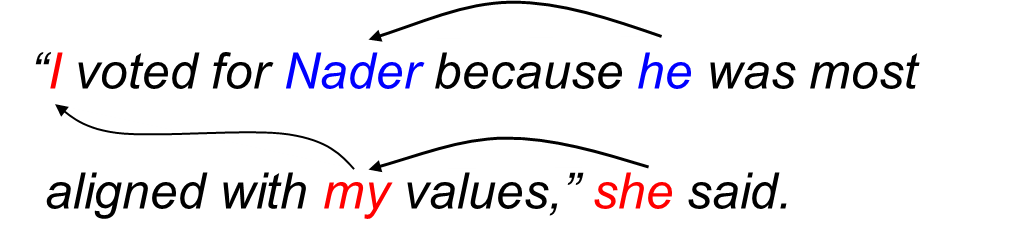

https://blog.devgenius.io/coreference-resolution-nlp-python-584c2ec50f5d